# Vectorise with NumPy: Performance Comparison

This notebook compares the **pure Python** implementation (`1. microgpt`) with the **NumPy-vectorized** implementation (`2. vectorise with numpy`).

Both implement the exact same GPT architecture:
- `n_embd=16`, `n_head=4`, `n_layer=1`, `block_size=16`
- Character-level tokenizer on a names dataset
- Hand-rolled autograd + Adam optimizer

The only difference: scalar Python loops vs. NumPy array operations.

In [1]:
import subprocess
import sys
import json
import os
import time
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12

## 1. Run Pure Python Version (50 steps)

The pure Python version is extremely slow (~8-10s per step), so we only run 50 steps for comparison.
We extrapolate the full 1000-step time from this.

In [2]:
PLAIN_STEPS = 50

print(f"Running pure Python microgpt for {PLAIN_STEPS} steps...")
print("(This will take several minutes)")

proc = subprocess.run(
    [sys.executable, 'run_plain.py', str(PLAIN_STEPS)],
    capture_output=True, text=True, timeout=1200
)
print(proc.stdout[-500:])
if proc.returncode != 0:
    print("STDERR:", proc.stderr[-500:])

Running pure Python microgpt for 50 steps...
(This will take several minutes)


2.6774 | 0.073s
step   50 /   50 | loss 2.6153 | 0.044s

total training time: 2.53s

--- inference (new, hallucinated names) ---
sample  1: jog
sample  2: jnai
sample  3: yiolaa
sample  4: jiaye
sample  5: yoaeaa
sample  6: jaone
sample  7: yrladve
sample  8: ohre
sample  9: hjoylle
sample 10: e
sample 11: j
sample 12: hodi
sample 13: pvlehh
sample 14: ooai
sample 15: aai
sample 16: mhoiayn
sample 17: jomi
sample 18: irlell
sample 19: lala
sample 20: cailaue

results saved to results_plain.json



## 2. Run NumPy-Vectorized Version (1000 steps)

In [3]:
NUMPY_STEPS = 1000

print(f"Running NumPy-vectorized microgpt for {NUMPY_STEPS} steps...")

proc = subprocess.run(
    [sys.executable, 'main.py'],
    capture_output=True, text=True, timeout=300
)
print(proc.stdout[-500:])
if proc.returncode != 0:
    print("STDERR:", proc.stderr[-500:])

Running NumPy-vectorized microgpt for 1000 steps...


 0.004s
step 1000 / 1000 | loss 2.6125 | 0.003s

total training time: 6.71s

--- inference (new, hallucinated names) ---
sample  1: gena
sample  2: sary
sample  3: jamya
sample  4: ame
sample  5: analen
sample  6: cany
sample  7: casar
sample  8: alydan
sample  9: lezan
sample 10: elyni
sample 11: anil
sample 12: karan
sample 13: fenlin
sample 14: aliea
sample 15: jaylon
sample 16: sarein
sample 17: saysan
sample 18: vandin
sample 19: adelen
sample 20: amyan

results saved to results_numpy.json



## 3. Load Results

In [4]:
with open('results_plain.json') as f:
    plain = json.load(f)

with open('results_numpy.json') as f:
    numpy_res = json.load(f)

print(f"Plain Python:  {plain['num_steps']} steps in {plain['total_train_time']:.2f}s")
print(f"NumPy:         {len(numpy_res['loss_log'])} steps in {numpy_res['total_train_time']:.2f}s")

Plain Python:  50 steps in 2.53s
NumPy:         1000 steps in 6.71s


## 4. Loss Curves

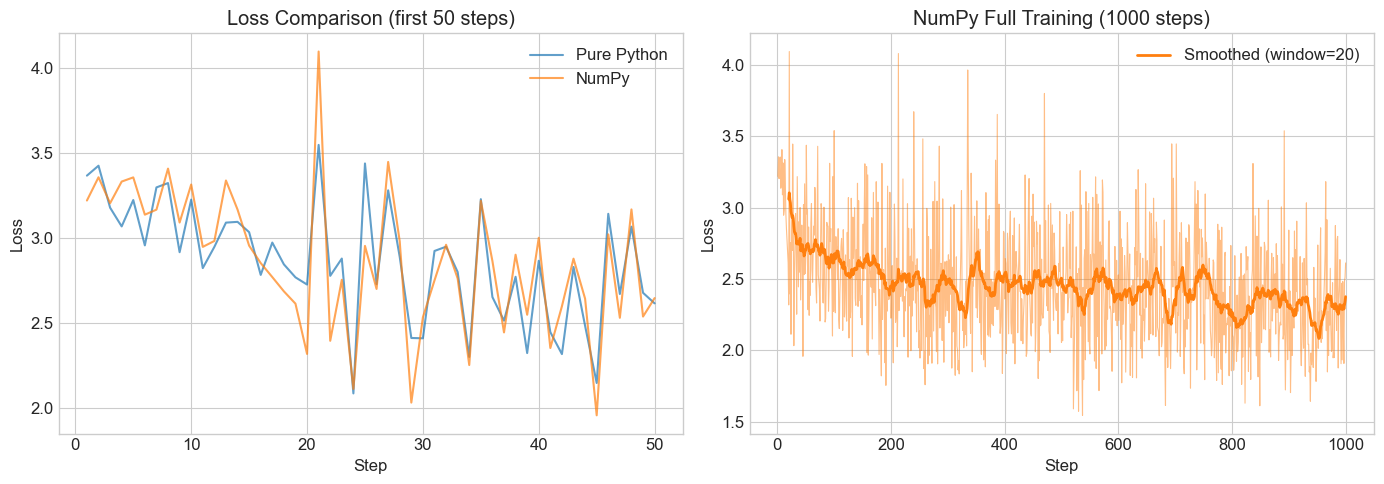

Saved: loss_curves.png


In [5]:
plain_steps = [e['step'] for e in plain['loss_log']]
plain_losses = [e['loss'] for e in plain['loss_log']]

numpy_steps = [e['step'] for e in numpy_res['loss_log']]
numpy_losses = [e['loss'] for e in numpy_res['loss_log']]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: both on same scale (first N steps)
n_compare = min(len(plain_steps), len(numpy_steps))
axes[0].plot(plain_steps[:n_compare], plain_losses[:n_compare], label='Pure Python', alpha=0.7, linewidth=1.5)
axes[0].plot(numpy_steps[:n_compare], numpy_losses[:n_compare], label='NumPy', alpha=0.7, linewidth=1.5)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Loss Comparison (first {n_compare} steps)')
axes[0].legend()

# Right: full numpy training curve
axes[1].plot(numpy_steps, numpy_losses, color='tab:orange', alpha=0.5, linewidth=0.8)
# Smoothed
window = 20
if len(numpy_losses) >= window:
    smoothed = np.convolve(numpy_losses, np.ones(window)/window, mode='valid')
    axes[1].plot(numpy_steps[window-1:], smoothed, color='tab:orange', linewidth=2, label=f'Smoothed (window={window})')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Loss')
axes[1].set_title('NumPy Full Training (1000 steps)')
axes[1].legend()

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: loss_curves.png")

## 5. Timing Comparison

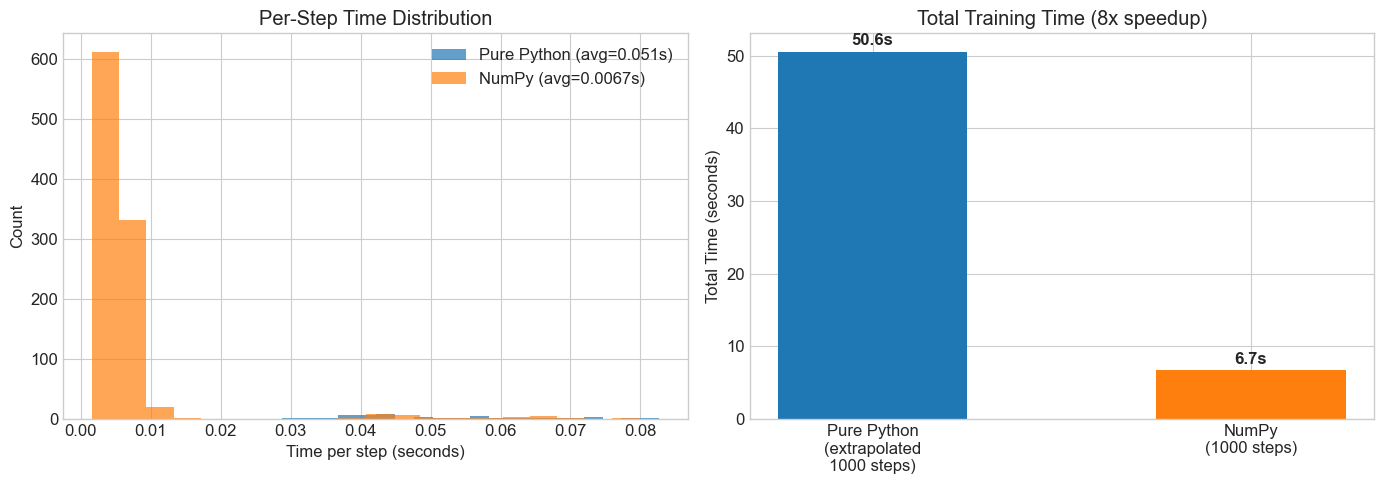

Saved: time_comparison.png


In [6]:
plain_times = [e['time'] for e in plain['loss_log']]
numpy_times = [e['time'] for e in numpy_res['loss_log']]

plain_avg_step = np.mean(plain_times)
numpy_avg_step = np.mean(numpy_times)
speedup = plain_avg_step / numpy_avg_step

# Extrapolate plain python to 1000 steps
plain_extrapolated_1000 = plain_avg_step * 1000

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: per-step time distribution
axes[0].hist(plain_times, bins=20, alpha=0.7, label=f'Pure Python (avg={plain_avg_step:.3f}s)', color='tab:blue')
axes[0].hist(numpy_times, bins=20, alpha=0.7, label=f'NumPy (avg={numpy_avg_step:.4f}s)', color='tab:orange')
axes[0].set_xlabel('Time per step (seconds)')
axes[0].set_ylabel('Count')
axes[0].set_title('Per-Step Time Distribution')
axes[0].legend()

# Right: total time bar chart
labels = ['Pure Python\n(extrapolated\n1000 steps)', 'NumPy\n(1000 steps)']
times = [plain_extrapolated_1000, numpy_res['total_train_time']]
colors = ['tab:blue', 'tab:orange']
bars = axes[1].bar(labels, times, color=colors, width=0.5)
for bar, t in zip(bars, times):
    if t > 60:
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                     f'{t/60:.1f} min', ha='center', va='bottom', fontweight='bold')
    else:
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{t:.1f}s', ha='center', va='bottom', fontweight='bold')
axes[1].set_ylabel('Total Time (seconds)')
axes[1].set_title(f'Total Training Time ({speedup:.0f}x speedup)')

plt.tight_layout()
plt.savefig('time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: time_comparison.png")

## 6. Summary Table

In [7]:
print("=" * 65)
print(f"{'Metric':<35} {'Pure Python':>12} {'NumPy':>12}")
print("=" * 65)
print(f"{'Parameters':.<35} {plain['num_params']:>12,} {numpy_res['num_params']:>12,}")
print(f"{'Training steps':.<35} {plain['num_steps']:>12,} {len(numpy_res['loss_log']):>12,}")
print(f"{'Avg time per step':.<35} {plain_avg_step:>11.3f}s {numpy_avg_step:>11.4f}s")
print(f"{'Total train time':.<35} {plain['total_train_time']:>11.1f}s {numpy_res['total_train_time']:>11.1f}s")
print(f"{'Estimated 1000-step time':.<35} {plain_extrapolated_1000:>11.1f}s {numpy_res['total_train_time']:>11.1f}s")
print(f"{'Final loss (at step shown)':.<35} {plain_losses[-1]:>12.4f} {numpy_losses[-1]:>12.4f}")
print(f"{'Speedup (per step)':.<35} {'1x':>12} {f'{speedup:.0f}x':>12}")
print("=" * 65)

Metric                               Pure Python        NumPy
Parameters.........................        4,192        4,192
Training steps.....................           50        1,000
Avg time per step..................       0.051s      0.0067s
Total train time...................         2.5s         6.7s
Estimated 1000-step time...........        50.6s         6.7s
Final loss (at step shown).........       2.6153       2.6125
Speedup (per step).................           1x           8x


## 7. Generated Samples Comparison

In [8]:
print(f"{'#':<4} {'Pure Python (50 steps)':>25} {'NumPy (1000 steps)':>25}")
print("-" * 56)
for i in range(20):
    p = plain['samples'][i] if i < len(plain['samples']) else ''
    n = numpy_res['samples'][i] if i < len(numpy_res['samples']) else ''
    print(f"{i+1:<4} {p:>25} {n:>25}")

print("\nNote: The pure Python model has only trained for 50 steps,")
print("so its samples are lower quality than the numpy model at 1000 steps.")

#       Pure Python (50 steps)        NumPy (1000 steps)
--------------------------------------------------------
1                          jog                      gena
2                         jnai                      sary
3                       yiolaa                     jamya
4                        jiaye                       ame
5                       yoaeaa                    analen
6                        jaone                      cany
7                      yrladve                     casar
8                         ohre                    alydan
9                      hjoylle                     lezan
10                           e                     elyni
11                           j                      anil
12                        hodi                     karan
13                      pvlehh                    fenlin
14                        ooai                     aliea
15                         aai                    jaylon
16                     mhoiayn 

## 8. Per-Step Time Over Training

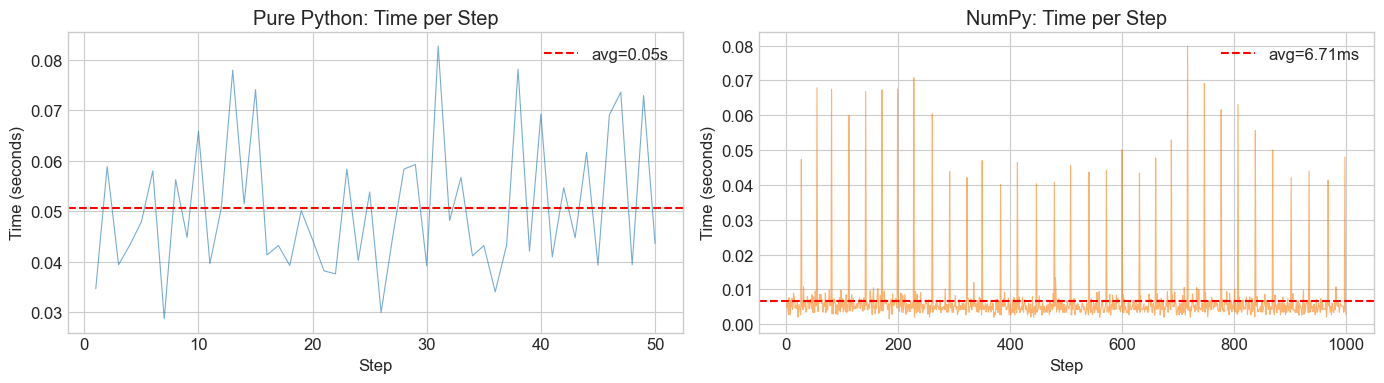

Saved: step_times.png


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(plain_steps, plain_times, alpha=0.6, linewidth=0.8)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Pure Python: Time per Step')
axes[0].axhline(y=plain_avg_step, color='r', linestyle='--', label=f'avg={plain_avg_step:.2f}s')
axes[0].legend()

axes[1].plot(numpy_steps, numpy_times, alpha=0.6, linewidth=0.8, color='tab:orange')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('NumPy: Time per Step')
axes[1].axhline(y=numpy_avg_step, color='r', linestyle='--', label=f'avg={numpy_avg_step*1000:.2f}ms')
axes[1].legend()

plt.tight_layout()
plt.savefig('step_times.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: step_times.png")